# NIHCXR Clinical Drift Experiments Tutorial

## Import Libraries and Load NIHCXR Dataset

In [1]:
from functools import partial

from monai.transforms import AddChanneld, Compose, Lambdad, Resized, ToDeviced
from torchxrayvision.models import DenseNet

from cyclops.data.loader import load_nihcxr
from cyclops.data.slicer import SliceSpec
from cyclops.data.utils import apply_transforms
from cyclops.monitor import ClinicalShiftApplicator, Detector, Reductor, TSTester
from cyclops.monitor.plotter import plot_drift_experiment, plot_drift_timeseries
from cyclops.monitor.utils import get_device

device = get_device()

nih_ds = load_nihcxr("/mnt/data/clinical_datasets/NIHCXR")

/home/amritk/.cache/pypoetry/virtualenvs/pycyclops-mhx6UJW0-py3.9/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Example 1. Generate Source/Target Dataset for Experiments (1-2)

In [2]:
shifter = ClinicalShiftApplicator(
    "sex", source=None, target="F", shift_id="Patient Gender"
)
source_ds, target_ds = shifter.apply_shift(nih_ds, num_proc=6)

transforms = Compose(
    [
        AddChanneld(keys=("features",), allow_missing_keys=True),
        Resized(
            keys=("features",), spatial_size=(1, 224, 224), allow_missing_keys=True
        ),
        Lambdad(
            keys=("features",),
            func=lambda x: ((2 * (x / 255.0)) - 1.0) * 1024,
            allow_missing_keys=True,
        ),
        ToDeviced(keys=("features",), device=device, allow_missing_keys=True),
    ]
)

source_ds = source_ds.with_transform(
    partial(apply_transforms, transforms=transforms),
    columns=["features"],
    output_all_columns=True,
)
target_ds = target_ds.with_transform(
    partial(apply_transforms, transforms=transforms),
    columns=["features"],
    output_all_columns=True,
)

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 69778.98 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:00, 96722.76 examples/s]

Filter (num_proc=6):  49%|████▉     | 55374/112120 [00:00<00:00, 107422.51 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:00<00:00, 143812.94 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:00<00:00, 149000.75 examples/s]

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 77806.92 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:00, 110495.12 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 133518.15 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 141855.05 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:00<00:00, 146994.53 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:00<00:00, 150653.38 examples/s]

## Example 2. Sensitivity test experiment with 3 dimensionality reduction techniques


Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 17.28 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 30.29 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 40.24 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 47.23 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 52.61 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 56.25 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 55.82 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.94 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.64 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:01<00:03, 19.40 examples/s]

Map:  64%|██████▍   | 64/100 [00:02<00:01, 31.35 examples/s]

Map:  96%|█████████▌| 96/100 [00:02<00:00, 39.28 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:08, 19.23 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 31.96 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 40.48 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 46.14 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 50.41 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 52.46 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 51.51 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 17.59 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 29.82 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 37.33 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 43.02 examples/s]

Map:  80%|████████  | 160/200 [00:04<00:00, 47.20 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 49.80 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 49.33 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.47 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.66 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:01<00:03, 18.35 examples/s]

Map:  64%|██████▍   | 64/100 [00:02<00:01, 29.36 examples/s]

Map:  96%|█████████▌| 96/100 [00:03<00:00, 36.30 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 16.89 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 27.65 examples/s]

Map:  48%|████▊     | 96/200 [00:03<00:03, 34.34 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 39.38 examples/s]

Map:  80%|████████  | 160/200 [00:04<00:00, 43.36 examples/s]

Map:  96%|█████████▌| 192/200 [00:05<00:00, 45.67 examples/s]

Map: 100%|██████████| 200/200 [00:05<00:00, 45.09 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:08, 19.76 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 32.63 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 41.62 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 48.29 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 52.74 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 54.79 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 55.10 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.50 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.24 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:01<00:03, 19.27 examples/s]

Map:  64%|██████▍   | 64/100 [00:02<00:01, 31.47 examples/s]

Map:  96%|█████████▌| 96/100 [00:02<00:00, 39.52 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:08, 19.36 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 31.45 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 39.26 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 43.87 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 47.87 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 49.97 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 50.12 examples/s]

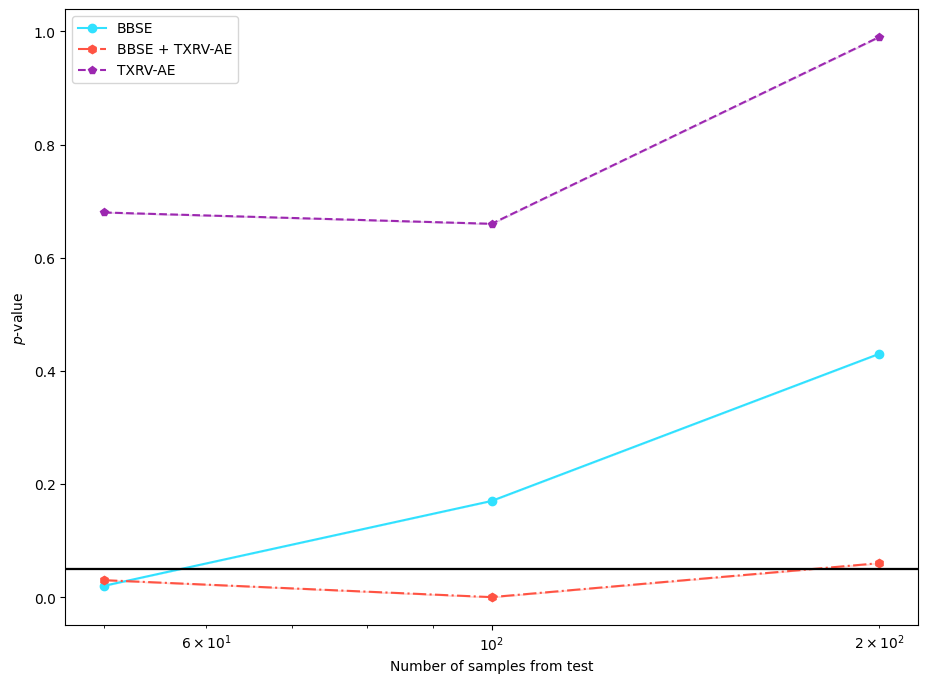

In [3]:
model = DenseNet(weights="densenet121-res224-all")
dr_methods = {
    "BBSE": "bbse-soft",
    "BBSE + TXRV-AE": "bbse-soft+txrv-ae",
    "TXRV-AE": "txrv-ae",
}
results = {}

for name, dr_method in dr_methods.items():
    if name == "TXRV-AE":
        reductor = Reductor(dr_method=dr_method, device=device)
    else:
        reductor = Reductor(dr_method=dr_method, model=model, device=device)
    detector = Detector(
        "sensitivity_test",
        reductor=reductor,
        tester=TSTester(tester_method="mmd"),
        source_sample_size=200,
        target_sample_size=[50, 100, 200],
        num_runs=1,
    )
    result = detector.detect_shift(source_ds, target_ds)
    results[name] = result
plot_drift_experiment(results)

## Example 3. Sensitivity test experiment with models trained on different datasets

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:08, 19.78 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 33.79 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 42.73 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 49.04 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 54.19 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 57.21 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 56.65 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 19.13 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.90 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:01<00:03, 17.50 examples/s]

Map:  64%|██████▍   | 64/100 [00:02<00:01, 28.00 examples/s]

Map:  96%|█████████▌| 96/100 [00:03<00:00, 34.03 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 17.58 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 27.28 examples/s]

Map:  48%|████▊     | 96/200 [00:03<00:03, 33.88 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 37.75 examples/s]

Map:  80%|████████  | 160/200 [00:04<00:00, 40.87 examples/s]

Map:  96%|█████████▌| 192/200 [00:05<00:00, 42.29 examples/s]

Map: 100%|██████████| 200/200 [00:05<00:00, 42.29 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:08, 19.95 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 33.84 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 43.30 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 46.43 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 52.17 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 55.47 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 55.24 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 19.04 examples/s]

Map: 100%|██████████| 50/50 [00:01<00:00, 27.36 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:01<00:03, 19.78 examples/s]

Map:  64%|██████▍   | 64/100 [00:02<00:01, 32.00 examples/s]

Map:  96%|█████████▌| 96/100 [00:02<00:00, 40.59 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:08, 19.24 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 31.80 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 40.50 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 46.30 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 50.47 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 52.28 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 51.60 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:08, 19.60 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 33.41 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 43.22 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 49.53 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 54.97 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 56.79 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 56.10 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 19.56 examples/s]

Map: 100%|██████████| 50/50 [00:01<00:00, 27.87 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:01<00:03, 19.49 examples/s]

Map:  64%|██████▍   | 64/100 [00:02<00:01, 32.48 examples/s]

Map:  96%|█████████▌| 96/100 [00:02<00:00, 41.43 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:08, 19.39 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 32.36 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 40.88 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 47.12 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 51.74 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 53.47 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 53.16 examples/s]

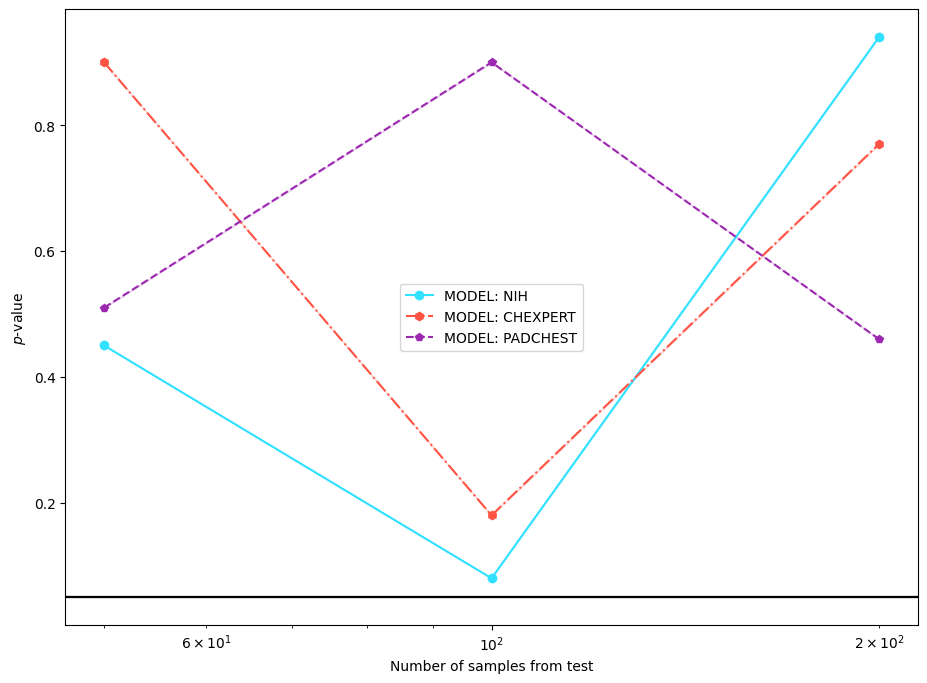

In [4]:
models = {
    "MODEL: NIH": "densenet121-res224-nih",
    "MODEL: CHEXPERT": "densenet121-res224-chex",
    "MODEL: PADCHEST": "densenet121-res224-pc",
}
results = {}

for model_name, model in models.items():
    detector = Detector(
        "sensitivity_test",
        reductor=Reductor(
            dr_method="bbse-soft", model=DenseNet(weights=model), device=device
        ),
        tester=TSTester(tester_method="mmd"),
        source_sample_size=200,
        target_sample_size=[50, 100, 200],
        num_runs=1,
    )
    results[model_name] = detector.detect_shift(source_ds, target_ds)
plot_drift_experiment(results)

## Example 4. Sensitivity test experiment with different clinical shifts

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 52290.60 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:00, 81489.32 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 95876.68 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 97428.62 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:00<00:00, 105896.64 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 110485.06 examples/s]

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 52272.40 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:00, 77507.59 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 91950.30 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 100449.40 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:00<00:00, 105288.34 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 110000.26 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:08, 20.06 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 33.90 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 43.39 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 49.71 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 54.40 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 56.93 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 56.35 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 19.24 examples/s]

Map: 100%|██████████| 50/50 [00:01<00:00, 27.25 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:01<00:03, 19.03 examples/s]

Map:  64%|██████▍   | 64/100 [00:02<00:01, 31.43 examples/s]

Map:  96%|█████████▌| 96/100 [00:02<00:00, 40.02 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 18.55 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 30.94 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 38.96 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 44.96 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 49.53 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 52.66 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 52.37 examples/s]

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 52917.46 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:00, 76982.47 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 90647.88 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 99049.69 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:01<00:00, 104833.77 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 109239.31 examples/s]

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 51984.26 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:00, 76066.11 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 83111.30 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 94537.28 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:01<00:00, 100915.25 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 105852.91 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:08, 19.98 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 33.98 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 43.20 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 50.45 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 55.23 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 57.53 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 56.87 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 19.37 examples/s]

Map: 100%|██████████| 50/50 [00:01<00:00, 27.79 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:01<00:03, 19.42 examples/s]

Map:  64%|██████▍   | 64/100 [00:02<00:01, 32.36 examples/s]

Map:  96%|█████████▌| 96/100 [00:02<00:00, 40.26 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 17.80 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 30.38 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 38.89 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 45.20 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 50.01 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 52.25 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 52.00 examples/s]

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 58290.70 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:00, 83358.12 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 96767.16 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 104666.08 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:00<00:00, 106518.11 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 111912.95 examples/s]

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 51976.51 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:01, 73443.99 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 83331.21 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 91590.43 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:01<00:00, 100519.74 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 106247.50 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:08, 19.53 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 33.28 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 42.80 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 49.56 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 54.27 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 57.30 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 56.94 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 19.23 examples/s]

Map: 100%|██████████| 50/50 [00:01<00:00, 27.48 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:01<00:03, 19.27 examples/s]

Map:  64%|██████▍   | 64/100 [00:02<00:01, 31.66 examples/s]

Map:  96%|█████████▌| 96/100 [00:02<00:00, 40.60 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:08, 18.78 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 31.24 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 39.93 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 46.14 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 50.03 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 51.81 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 51.21 examples/s]

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 53663.05 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:00, 79240.43 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 93211.77 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 99932.44 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:00<00:00, 107956.56 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 109699.50 examples/s]

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 50547.93 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:00, 75455.68 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 89816.14 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 102041.20 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:00<00:00, 106511.93 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 111272.42 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:08, 20.25 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 33.97 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 43.33 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 49.62 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 54.52 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 57.11 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 56.62 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.98 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.94 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:01<00:03, 19.43 examples/s]

Map:  64%|██████▍   | 64/100 [00:02<00:01, 32.59 examples/s]

Map:  96%|█████████▌| 96/100 [00:02<00:00, 41.01 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 17.23 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 29.78 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 38.98 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 45.33 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 49.79 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 52.59 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 52.19 examples/s]

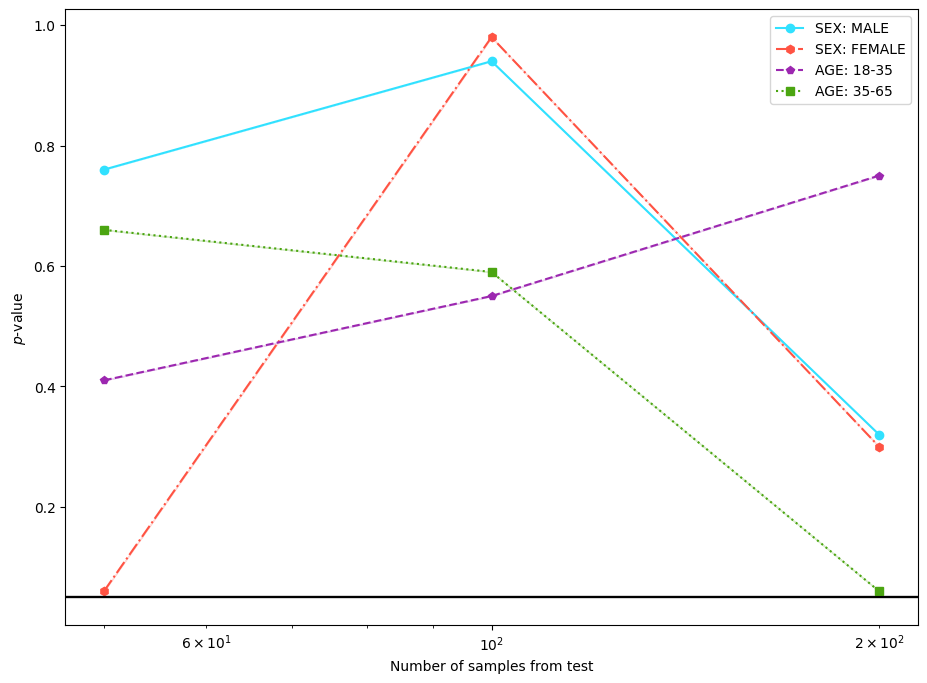

In [5]:
model = DenseNet(weights="densenet121-res224-all")
source_slice = None
target_slices = {
    "SEX: MALE": SliceSpec(spec_list=[{"Patient Gender": {"value": "M"}}]),
    "SEX: FEMALE": SliceSpec(spec_list=[{"Patient Gender": {"value": "F"}}]),
    "AGE: 18-35": SliceSpec(
        spec_list=[{"Patient Age": {"min_value": 18, "max_value": 35}}]
    ),
    "AGE: 35-65": SliceSpec(
        spec_list=[{"Patient Age": {"min_value": 35, "max_value": 65}}]
    ),
}
results = {}

for name, target_slice in target_slices.items():
    source_slice = None
    shifter = ClinicalShiftApplicator(
        "custom", source=source_slice, target=target_slice
    )
    ds_source, ds_target = shifter.apply_shift(nih_ds, num_proc=6)

    ds_source = ds_source.with_transform(
        partial(apply_transforms, transforms=transforms),
        columns=["features"],
        output_all_columns=True,
    )
    ds_target = ds_target.with_transform(
        partial(apply_transforms, transforms=transforms),
        columns=["features"],
        output_all_columns=True,
    )

    detector = Detector(
        "sensitivity_test",
        reductor=Reductor(dr_method="bbse-soft", model=model, device=device),
        tester=TSTester(tester_method="mmd"),
        source_sample_size=200,
        target_sample_size=[50, 100, 200],
        num_runs=1,
    )
    results[name] = detector.detect_shift(ds_source, ds_target)
plot_drift_experiment(results)

## Example 5. Rolling window experiment with synthetic timestamps using biweekly window

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:08, 19.73 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 33.76 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 43.41 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 50.18 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 55.37 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 57.37 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 56.91 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 19.45 examples/s]

Map: 100%|██████████| 50/50 [00:01<00:00, 27.38 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 19.35 examples/s]

Map: 100%|██████████| 50/50 [00:01<00:00, 27.26 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.99 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.97 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.81 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.97 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.39 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 24.89 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 19.25 examples/s]

Map: 100%|██████████| 50/50 [00:01<00:00, 27.10 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.76 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.84 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.91 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.36 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.67 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.71 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 19.78 examples/s]

Map: 100%|██████████| 50/50 [00:01<00:00, 27.80 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 19.25 examples/s]

Map: 100%|██████████| 50/50 [00:01<00:00, 27.51 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 19.61 examples/s]

Map: 100%|██████████| 50/50 [00:01<00:00, 27.96 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 19.40 examples/s]

Map: 100%|██████████| 50/50 [00:01<00:00, 27.72 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 19.69 examples/s]

Map: 100%|██████████| 50/50 [00:01<00:00, 28.12 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 19.30 examples/s]

Map: 100%|██████████| 50/50 [00:01<00:00, 27.87 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 19.96 examples/s]

Map: 100%|██████████| 50/50 [00:01<00:00, 28.51 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 19.36 examples/s]

Map: 100%|██████████| 50/50 [00:01<00:00, 27.40 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 19.64 examples/s]

Map: 100%|██████████| 50/50 [00:01<00:00, 27.81 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 18.00 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.99 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 19.55 examples/s]

Map: 100%|██████████| 50/50 [00:01<00:00, 27.53 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 19.73 examples/s]

Map: 100%|██████████| 50/50 [00:01<00:00, 28.19 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 19.51 examples/s]

Map: 100%|██████████| 50/50 [00:01<00:00, 27.66 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 19.11 examples/s]

Map: 100%|██████████| 50/50 [00:01<00:00, 27.54 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 19.70 examples/s]

Map: 100%|██████████| 50/50 [00:01<00:00, 27.99 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 19.46 examples/s]

Map: 100%|██████████| 50/50 [00:01<00:00, 27.92 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 19.42 examples/s]

Map: 100%|██████████| 50/50 [00:01<00:00, 28.00 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 20.04 examples/s]

Map: 100%|██████████| 50/50 [00:01<00:00, 28.73 examples/s]

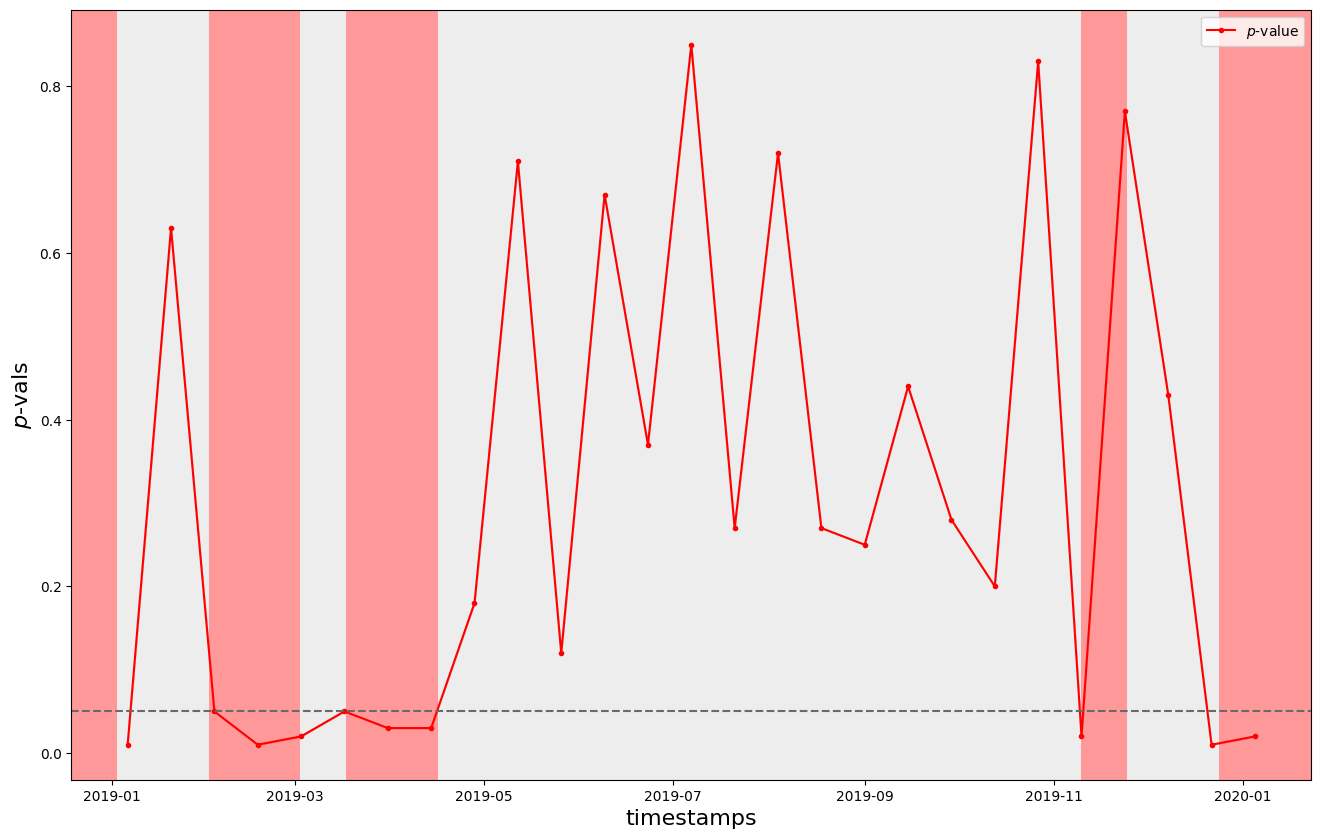

In [6]:
model = DenseNet(weights="densenet121-res224-all")
detector = Detector(
    "rolling_window_drift",
    reductor=Reductor(dr_method="bbse-soft", model=model, device=device),
    tester=TSTester(tester_method="mmd"),
    source_sample_size=200,
    target_sample_size=50,
    timestamp_column="timestamp",
    window_size="2W",
)

results = detector.detect_shift(source_ds, target_ds)
plot_drift_timeseries(results)